In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import random_split, DataLoader
from PIL import Image
import torchvision.transforms as T
import pandas as pd

#For RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

import matplotlib.pyplot as plt

In [2]:
class NutritionEstimator(nn.Module):
    def __init__(self):
        super().__init__()
        
        resnet = models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])   
        
        self.flatten = nn.Flatten()
        
        # 預測卡路里
        self.head_cal = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        # 預測脂肪
        self.head_fat = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        # 預測蛋白質
        self.head_protein = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        # 預測碳水化合物
        self.head_carb = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.backbone(x)  # (B, 2048, 1, 1) 
        x = self.flatten(x)   # (B, 2048)
        
        cal = self.head_cal(x)
        fat = self.head_fat(x)
        protein = self.head_protein(x)
        carb = self.head_carb(x)

        return cal, fat, protein, carb


In [3]:
class FoodDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform or T.Compose([
            T.RandomResizedCrop(224),
            T.RandomHorizontalFlip(),
            T.ColorJitter(brightness=0.2, contrast=0.2),
            T.RandomRotation(10),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 調整圖片路徑和欄位名稱
        image_path = f"{self.img_dir}/{row['filename']}"
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # 取出對應營養素欄位
        label = torch.tensor([
            row['Calories(kcal)'],
            row['Fat(g)'],
            row['Protein(g)'],
            row['Carbohydrates(g)']
        ], dtype=torch.float)

        return image, label

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NutritionEstimator()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/home/imfoodtrack/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/imfoodtrack/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
full_data = pd.read_csv('data.csv')
num_samples = len(full_data)
torch.manual_seed(42) 
indices = torch.randperm(len(full_data))
train_indices = indices[:1000].tolist()
test_indices = indices[1000:].tolist()

# 分別建立 DataLoader
train_dataset = FoodDataset(csv_path='data.csv', img_dir='raw_data/lunch_box')
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

model.train()

# 凍結 backbone，讓它不會被訓練
for param in model.backbone.parameters():
    param.requires_grad = False

num_epochs = 30
epoch_losses = []  # 記錄每個 epoch 的 loss

for epoch in range(num_epochs):
    running_loss = 0.0
    all_biases = []  # 收集偏誤

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # 預測4個營養素
        cal, fat, protein, carb = model(images)
        cal = cal.squeeze()
        fat = fat.squeeze()
        protein = protein.squeeze()
        carb = carb.squeeze()

        # 計算每個 loss
        loss = (
            criterion(cal, labels[:, 0]) +
            criterion(fat, labels[:, 1]) +
            criterion(protein, labels[:, 2]) +
            criterion(carb, labels[:, 3])
        )

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

Epoch 1 | Loss: 378822.8538
Epoch 2 | Loss: 92924.2156
Epoch 3 | Loss: 23466.3476
Epoch 4 | Loss: 23786.4503
Epoch 5 | Loss: 23606.6615
Epoch 6 | Loss: 22561.5649
Epoch 7 | Loss: 21402.4100
Epoch 8 | Loss: 21465.5625
Epoch 9 | Loss: 20588.4164
Epoch 10 | Loss: 20546.3272
Epoch 11 | Loss: 19136.0160
Epoch 12 | Loss: 18360.7534
Epoch 13 | Loss: 18382.4374
Epoch 14 | Loss: 18094.0174
Epoch 15 | Loss: 16747.8629
Epoch 16 | Loss: 17870.6423
Epoch 17 | Loss: 17331.8521
Epoch 18 | Loss: 16501.3271
Epoch 19 | Loss: 16117.1376
Epoch 20 | Loss: 16000.6213
Epoch 21 | Loss: 15902.6835
Epoch 22 | Loss: 15161.6274
Epoch 23 | Loss: 15655.3195
Epoch 24 | Loss: 15225.1562
Epoch 25 | Loss: 16205.6258
Epoch 26 | Loss: 15772.7114
Epoch 27 | Loss: 15145.8225
Epoch 28 | Loss: 14982.7733
Epoch 29 | Loss: 14517.9281
Epoch 30 | Loss: 14796.3999


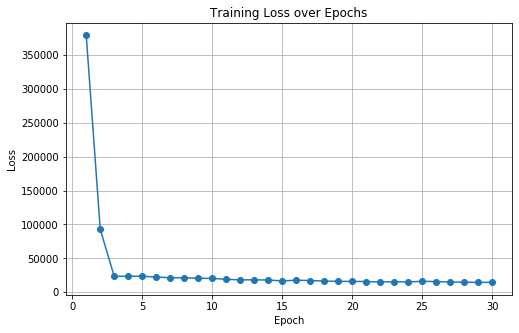

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [7]:
torch.save(model.state_dict(), 'resnet_model.pth')

In [8]:
full_data = pd.read_csv('data.csv')
num_samples = len(full_data)
indices = torch.randperm(len(full_data))
train_indices = indices[:1000].tolist()
test_indices = indices[1000:].tolist()

# 1. 載入模型
model = NutritionEstimator()
model.load_state_dict(torch.load("resnet_model.pth", map_location=device))
model.to(device)
model.eval()

# 2. 建立測試資料集與 DataLoader
test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor()
])

test_dataset = FoodDataset(csv_path='data.csv', img_dir='raw_data/lunch_box', transform=test_transform)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# 3. 收集所有的預測與真實值
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)  
        preds = torch.stack(preds, dim=1)  
        
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# 4. 計算 RMSE
all_preds = torch.cat(all_preds).squeeze().numpy()
all_labels = torch.cat(all_labels).squeeze().numpy()

rmse = np.sqrt(mean_squared_error(all_labels, all_preds, multioutput='raw_values'))

bias_std = np.std(all_labels, axis=0)

print("RMSE 結果：")
print(f"卡路里 RMSE：{rmse[0]:.2f} kcal")
print(f"脂肪 RMSE：{rmse[1]:.2f} g")
print(f"蛋白質 RMSE：{rmse[2]:.2f} g")
print(f"碳水化合物 RMSE：{rmse[3]:.2f} g")
print(f"Testing bias std (Baseline)：{bias_std} ")

/home/imfoodtrack/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/imfoodtrack/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RMSE 結果：
卡路里 RMSE：115.02 kcal
脂肪 RMSE：6.93 g
蛋白質 RMSE：15.75 g
碳水化合物 RMSE：19.55 g
Testing bias std：[124.599525   8.712504  15.901192  20.371632] 
